# Section 1: Business understanding

# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Question 1. How different gender types responded to the offers send to them?
# Question 2. What is the distribution of new customers comming to starbucks?
# Question 3. How different age groups responded to the offers send to them?

# Section 2: Data Understanding

Import necessary libraries

In [107]:
import pandas as pd
import numpy as np
import math
import json
pd.set_option('display.max_rows', 40)
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
%matplotlib inline

# Gather Data

Let us start with uploading the data

In [2]:
# read in the json files

portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

define a function which will be used to categorize continuous variables

In [3]:
def categorize(df, col, nbins=10, quantiles=True):
    '''
    categorize continuous variable in a dataframe
    
    Input
    df - pandas dataframe
    col - column name of a continuoues variable in the dataframe
    nbins - number of bins to which a column will be categorized
    quantiles - if true categorization of the variable will be based on quantile bins. 
                When False bins will be set in a uniform way 
    Returns
    df1 - a copy of df dataframe with additional categorised column 
    
    '''
    
    df1=df.copy()
    if quantiles:
        
        # create bin values based on quantiles
        quantiles = [df[col].quantile(0.1*i) for i in range(nbins)]
        bins=np.unique(quantiles)
        bins = np.append(-np.inf, bins)
        bins = np.append(bins, np.inf)
        categorized = pd.cut(df1[col], bins=bins, right=True, labels=[i for i in range(len(bins)-1)], include_lowest=True)
    
        
    else:
        
        #create uniform bins values
        col_min, col_max = df[col].min(), df[col].max() 
        bins = [col_min+(col_max-col_min)/nbins*i for i in range(nbins)]
        bins = np.unique(bins)
        bins = np.append(-np.inf, bins)
        bins = np.append(bins, np.inf)
        categorized = pd.cut(df1[col], bins=bins, right=True, labels=[i for i in range(len(bins)-1)])
    col=col+'_categorized'
    df1[col] = categorized
    return df1

# Explore data

In [4]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [8]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [9]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [10]:
# transcript[transcript.event == 'offer received'].value.apply(lambda x: x.keys()).value_counts()
# transcript[transcript.event=='offer viewed'].value.apply(lambda x: x.keys()).value_counts()
# transcript[transcript.event=='offer completed'].value.apply(lambda x: x.keys()).value_counts()
# transcript[transcript.event=='transaction'].value.apply(lambda x: x.keys()).value_counts()

Let's take a look at some interesting variables which we will later use

In [11]:
# First we need to replace age 118, because it is NA in the dataset
profile[profile.age==118]['age'] = np.NaN
profile = categorize(profile, 'age', nbins=10, quantiles=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Age distribution')

<Figure size 720x864 with 0 Axes>

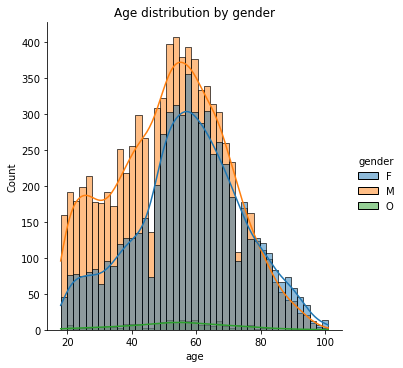

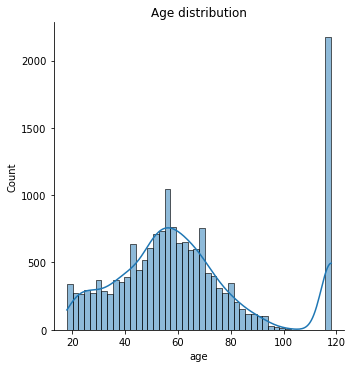

In [12]:
plt.figure(figsize=(10,12))
sns.displot(data=profile, x='age', kde=True, hue= 'gender')
plt.title('Age distribution by gender')

sns.displot(data=profile, x='age', kde=True)
plt.title('Age distribution')


## Income

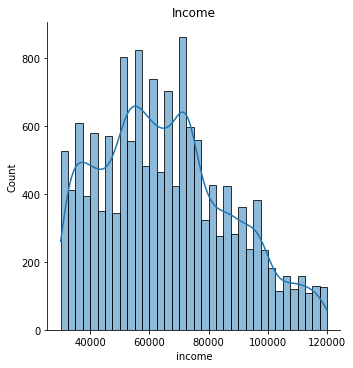

Text(0.5, 1.0, 'Income by gender')

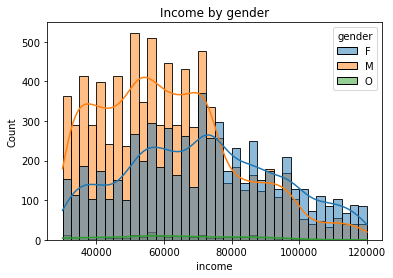

In [13]:
sns.displot(data=profile, x='income', kde=True)
plt.title('Income')
plt.show()
sns.histplot(data=profile, x='income', kde=True, hue = 'gender')
plt.title('Income by gender')

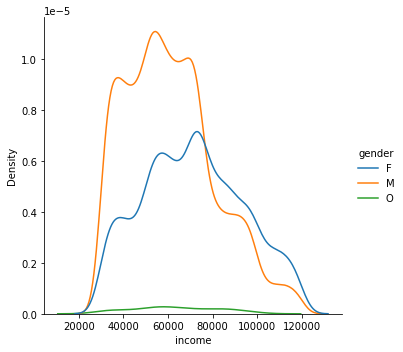

In [14]:
sns.displot(data=profile, x='income', kind='kde', hue = 'gender')

Conclusion: we can observe that woman receive grater income than man

<AxesSubplot:xlabel='gender', ylabel='count'>

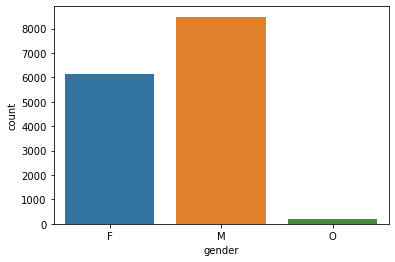

In [15]:
sns.countplot(x='gender', data=profile)

# 1) Data cleaning and preparation

In order to clean the data we will first create a column indicating whether a certain kind of offerd send to a given customer was sucessful or failed that means customer didn't realize the offer. Because we will analyse only whether a customer responded to this type of offer regardless of the number of times this offer was send to that customer

In [19]:
# # Lets unpack the key and value from value column into separate columns

transcript['key'] = transcript.value.apply(lambda x: list(x.keys())[0])
transcript['val'] = transcript.value.apply(lambda x: list(x.values())[0])
transcript.drop('value', axis=1, inplace=True)

We will start cleaning by merging transcript with profile tables

In [20]:
# merge transcript with profile

transcript_profile = pd.merge(transcript, profile, right_on = 'id', left_on ='person')

In [21]:
transcript_profile.head()

,person,event,time,key,val,gender,age,id,became_member_on,income,age_categorized
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,6
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,6
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,amount,19.89,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,6
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,6
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,amount,17.78,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,6


Chceck whether a given person can receive a given offer several times

In [22]:
transcript[transcript.event=='offer received'].groupby(['person', 'val']).count()

event  \
person                           val                                       
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5      1   
                                 3f207df678b143eea3cee63160fa8bed      1   
                                 5a8bc65990b245e5a138643cd4eb9837      1   
                                 f19421c1d4aa40978ebb69ca19b0e20d      1   
                                 fafdcd668e3743c1bb461111dcafc2a4      1   
...                                                                  ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d      2   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7      1   
                                 2906b810c7d4411798c6938adc9daaa5      3   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9      1   
                                 fafdcd668e3743c1bb461111dcafc2a4      1   

                                                                   time  key  
person                           val                                          
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5     1    1  
                                 3f207df678b143eea3cee63160fa8bed     1    1  
                                 5a8bc65990b245e5a138643cd4eb9837     1    1  
                                 f19421c1d4aa40978ebb69ca19b0e20d     1    1  
                                 fafdcd668e3743c1bb461111dcafc2a4     1    1  
...                                                                 ...  ...  
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d     2    2  
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7     1    1  
                                 2906b810c7d4411798c6938adc9daaa5     3    3  
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9     1    1  
                                 fafdcd668e3743c1bb461111dcafc2a4     1    1  

[63288 rows x 3 columns]

In [11]:
# conclusion: one person may receive the same offer a few times

We will have to differently approch informational and discount, bogo offers, because informational offers are completed in different way

Lets start with categorising informational offers into successful or failure columns

In [23]:
# Start with merging transcript and portfolio tables

transcript_portfolio = pd.merge(transcript, portfolio, how='outer', left_on='val', right_on = 'id')

In [24]:
# we consider only if the person applied the given informational offer
# we do not take into consideration how many times this offer was sent to that customer
# we will analyse only if after some time the customer responded to the offer

### Informational offers

In [25]:
# select only informational offers

inf_offers = transcript_portfolio[transcript_portfolio['offer_type'] == 'informational']
# select only transactions of a given customer
transactions = transcript_portfolio[transcript_portfolio.event=='transaction']

In [26]:
transactions.drop(['event', 'key','reward','channels','difficulty','duration','offer_type', 'id'], axis=1, inplace=True)
transactions.rename(columns={"val": "amount", "time": "transaction_time"}, inplace=True)
inf_offers.drop(['key',  'channels', 'offer_type', 'id'], axis=1, inplace=True)
inf_offers.rename(columns={"val":"offer_id", "time":"offer_time"}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
transactions

,person,transaction_time,amount
167581,02c083884c7d45b39cc68e1314fec56c,0,0.83
167582,e1251ca419a84273a8a974fe61d3c69e,12,0.83
167583,b94c7601b17b41609daa2e3e56c3f53d,24,0.83
167584,8c21762e5c1c4ea881f6a9989116b058,30,0.83
167585,7e70232d747043f1ae50f3bb41e32e91,30,0.83
...,...,...,...
306529,76018bc0dfd64ccc8f2e7959bf627ba7,708,290.93
306530,d81ed5c788bd49ec803bec849c64dbba,708,43.91
306531,a0f4c1aafeda4398a7afe66c37caf416,714,685.07
306532,692e3eaba5854ad5bbdd51d241647830,714,405.04


In [28]:
# We need to sort the tables by person and time the transaction was made
# because the order of events is crucial to say whether an offer impacted someone to buy a product 
# e.g. offer has to be viewed before making a transaction to say whether an offer was realized

transactions.sort_values(by=['person', 'transaction_time'], inplace=True)
inf_offers.sort_values(by=['person', 'offer_time'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
transactions = transactions.groupby(['person']).agg(list).reset_index()
customer_offers = inf_offers.groupby(['person', 'offer_id']).agg(list).reset_index()

In [30]:
transactions.head(3)

,person,transaction_time,amount
0,0009655768c64bdeb2e877511632db8f,"[228, 414, 528, 552, 576, 660, 690, 696]","[22.16, 8.57, 14.11, 13.56, 10.27, 12.36, 28.1..."
1,00116118485d4dfda04fdbaba9a87b5c,"[294, 456, 474]","[0.7000000000000001, 0.2, 3.19]"
2,0011e0d4e6b944f998e987f904e8c1e5,"[132, 252, 576, 642, 654]","[13.49, 11.93, 22.05, 23.03, 8.96]"


In [31]:
customer_offers.head(3)

,person,offer_id,event,offer_time,reward,difficulty,duration
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]","[336, 372]","[0.0, 0.0]","[0.0, 0.0]","[4.0, 4.0]"
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,"[offer received, offer viewed]","[168, 192]","[0.0, 0.0]","[0.0, 0.0]","[3.0, 3.0]"
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]","[0, 6]","[0.0, 0.0]","[0.0, 0.0]","[4.0, 4.0]"


Now let us merge transaction dataframe with the offers dataframe

In [32]:
transactions_offer = pd.merge(customer_offers, transactions, how='left', on='person')

In [33]:
transactions_offer.head(2)

,person,offer_id,event,offer_time,reward,difficulty,duration,transaction_time,amount
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]","[336, 372]","[0.0, 0.0]","[0.0, 0.0]","[4.0, 4.0]","[228, 414, 528, 552, 576, 660, 690, 696]","[22.16, 8.57, 14.11, 13.56, 10.27, 12.36, 28.1..."
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,"[offer received, offer viewed]","[168, 192]","[0.0, 0.0]","[0.0, 0.0]","[3.0, 3.0]","[228, 414, 528, 552, 576, 660, 690, 696]","[22.16, 8.57, 14.11, 13.56, 10.27, 12.36, 28.1..."


In the below look we will create a new column which determines whether an offer(here it is informational type of offer) was relised i.e. it is successful offer or it was failed offer. 

In [34]:
# for each customer and offer check if this offer was successful
# assume if offer was received 2 times and then viewed assume the latter one was viewed and previous is not successful

transactions_offer['successful'] = 0
transactions_offer['delete'] = 0
# merged['successful_all'] = 0
# merged['successful_all'] = merged['successful_all'].astype('object')
for i, row in transactions_offer.iterrows():
    
    # get locations of when the offer was viewed in the event list
    # assume from that time the offer starts being activated
    event = row['event']
    locs = [x for x in range(len(event)) if event[x]=='offer viewed']
    
    # suc = [0 for x in range(len(event)) if event[x]=='offer received'] 
    # check if there were moments when the offer was viewed
    # otherwise the offer was not completed
    if len(locs)>=1:
        
        # check if there were any transactions made
        # otherwise the offer couldn't be completed
        if not np.isnan(row['transaction_time']).all():
            transaction_time = row['transaction_time']

            # for each' offer view' check if it was successful
            for loc in locs:
                offer_start = row['offer_time'][loc]
                offer_duration = row['duration'][loc]
                #check if any transaction satisfies an offer
                # time 

                for j in transaction_time:
                    if j > offer_start and j-offer_start > offer_duration:
                        row['successful']=1
                        transactions_offer.loc[i, 'successful'] = 1
                        # the offer that was received just before it was viewed was valid and successful
                        # suc[loc-1] = 1
                        # merged.at[i, 'successful_all'] = list(suc)
    else:
        transactions_offer.loc[i, 'delete'] = 1
# we assume that if a customer saw an offer and did not complete it then the offer is failed
# if a customer didn't see an offer then we should delete this observation as it doesn't bing any useful information

        

In [35]:
# delete not needed observations
informational_offers = transactions_offer[transactions_offer.delete==0]

In [36]:
# delete unwanted columns
informational_offers.drop(columns=['event', 'offer_time', 'reward', 'difficulty', 'duration', 'transaction_time', 'amount','delete'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [37]:
informational_offers.head(2)

,person,offer_id,successful
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1


## Discount and bogo offers

Discount and Bogo offers have different specification than informational thus we need to set different conditions to determine whether an offer was successfully completed

In [38]:
# Select discount and BOGO offers from the dataset
dis_bogo_offers = transcript_portfolio[np.logical_or(transcript_portfolio['offer_type'] == 'bogo', transcript_portfolio['offer_type'] == 'discount')]

In [39]:
# Sort values by person and time when event happened
dis_bogo_offers = dis_bogo_offers.sort_values(by=['person','time'])

In [40]:
# Check unique values of event
dis_bogo_offers.event.unique()

array(['offer received', 'offer completed', 'offer viewed'], dtype=object)

In [41]:
# create dataframe grouped by person and offer send to this person. 
# Concatenate all the events related to an offer and person into one row

dis_bogo = pd.DataFrame(dis_bogo_offers.groupby(['person', 'val']).agg(list))

In [42]:
dis_bogo.head(2)

event  \
person                           val                                                                                 
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5                [offer received, offer completed]   
                                 f19421c1d4aa40978ebb69ca19b0e20d  [offer received, offer completed, offer viewed]   

                                                                              time  \
person                           val                                                 
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       [576, 576]   
                                 f19421c1d4aa40978ebb69ca19b0e20d  [408, 414, 456]   

                                                                                              key  \
person                           val                                                                
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5            [offer id, offer_id]   
                                 f19421c1d4aa40978ebb69ca19b0e20d  [offer id, offer_id, offer id]   

                                                                            reward  \
person                           val                                                 
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       [2.0, 2.0]   
                                 f19421c1d4aa40978ebb69ca19b0e20d  [5.0, 5.0, 5.0]   

                                                                                                            channels  \
person                           val                                                                                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       [[web, email, mobile], [web, email, mobile]]   
                                 f19421c1d4aa40978ebb69ca19b0e20d  [[web, email, mobile, social], [web, email, mo...   

                                                                        difficulty  \
person                           val                                                 
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5     [10.0, 10.0]   
                                 f19421c1d4aa40978ebb69ca19b0e20d  [5.0, 5.0, 5.0]   

                                                                          duration  \
person                           val                                                 
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       [7.0, 7.0]   
                                 f19421c1d4aa40978ebb69ca19b0e20d  [5.0, 5.0, 5.0]   

                                                                             offer_type  \
person                           val                                                      
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  [discount, discount]   
                                 f19421c1d4aa40978ebb69ca19b0e20d    [bogo, bogo, bogo]   

                                                                                                                  id  
person                           val                                                                                  
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  [2906b810c7d4411798c6938adc9daaa5, 2906b810c7d...  
                                 f19421c1d4aa40978ebb69ca19b0e20d  [f19421c1d4aa40978ebb69ca19b0e20d, f19421c1d4a...

In [43]:
# create column indicating whether an offer was successful or not

dis_bogo['success'] = 0

for i, row in dis_bogo.iterrows():

    # was the offer viewed and completed?
    if 'offer viewed' in row.event and 'offer completed' in row.event: 
        # was it viewed before completion? otherwise the offer is not successful 
        # check if the last 'offer completed' was after the first 'offer viewed'
        # then the customer at least once completed the offer after viewing it
        
        last_copleted = [idx for idx in range(len(row.event)) if row.event[idx]=='offer completed'][-1]
        first_viewed = [idx for idx in range(len(row.event)) if row.event[idx]=='offer viewed'][0]
        if last_copleted > first_viewed:
            # then the offer was successful
            dis_bogo.loc[i, 'success'] = 1
            
# create column indicating whether an offer was failure or not

dis_bogo.reset_index(inplace=True)
dis_bogo['failure'] = 0

for i, row in dis_bogo.iterrows():
    # was the offer viewed and not completed ? then the offer was a failure
    if 'offer viewed' in row.event and 'offer completed' not in row.event: 
        # then the offer failed
        dis_bogo.loc[i, 'failure'] = 1
    # was the last 'offer completed' event before last 'offer viewed' event?
    # If yes then we cannot conclude if the offer was successful 
    

In [39]:
# how many offers do we have in the dataset which were neither viewed nor received

print(np.logical_and(dis_bogo.success==0, dis_bogo.failure==0).sum())
print(np.logical_and(dis_bogo.success==0, dis_bogo.failure==1).sum())
print(np.logical_and(dis_bogo.success==1, dis_bogo.failure==0).sum())
print(np.logical_and(dis_bogo.success==1, dis_bogo.failure==1).sum())

13899
15366
21372
0


Conclusion:
there are bogo and discount offers which were neither failure nor successful.
They do not give any usefull information as we do not know e.g. whether someone would complete the offer if he saw it before.
Thus we will delete it

those may be offers which were received but not viewed, thus we will not use those offers

In [45]:
dis_bogo = dis_bogo[np.logical_or(dis_bogo.success==1, dis_bogo.failure==1)]

In [46]:
# lets drop failure column as now failure information is contained in the success column

dis_bogo.drop(['failure'], axis=1, inplace=True)

In [47]:
# lets delete not needed columns

dis_bogo.drop(columns=['event','time', 'key', 'reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], inplace=True)

In [48]:
# rename a few columns

dis_bogo.rename(columns={"val":"offer_id", "success": "successful"}, inplace=True)

In [49]:
dis_bogo.head(2)

,person,offer_id,successful
3,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1


In [50]:
informational_offers.head(2)

,person,offer_id,successful
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1


In [51]:
# Now we need to concatenate the above two tables

offer_success = pd.concat([dis_bogo, informational_offers])

In [52]:
offer_success.head(2)

,person,offer_id,successful
3,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1


In [54]:
# Now we have information whether a specific kind of offer sent to a given client was successful
# let us merge this table with information about the customers

In [55]:
data = pd.merge(offer_success, profile, how = 'left', left_on = 'person', right_on = 'id')


In [61]:
data.head()

,person,offer_id,successful,gender,age,id,became_member_on,income,age_categorized
0,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,None,NaN,00116118485d4dfda04fdbaba9a87b5c,20180425,NaN,10
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,O,40.0,0011e0d4e6b944f998e987f904e8c1e5,20180109,57000.0,3
2,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,O,40.0,0011e0d4e6b944f998e987f904e8c1e5,20180109,57000.0,3
3,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,O,40.0,0011e0d4e6b944f998e987f904e8c1e5,20180109,57000.0,3
4,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,F,59.0,0020c2b971eb4e9188eac86d93036a77,20160304,90000.0,5


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46047 entries, 0 to 46046
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   person            46047 non-null  object  
 1   offer_id          46047 non-null  object  
 2   successful        46047 non-null  int64   
 3   gender            39447 non-null  object  
 4   age               39447 non-null  float64 
 5   id                46047 non-null  object  
 6   became_member_on  46047 non-null  int64   
 7   income            39447 non-null  float64 
 8   age_categorized   46047 non-null  category
dtypes: category(1), float64(2), int64(2), object(4)
memory usage: 3.2+ MB


In [57]:
data.shape

(46047, 9)

Now we have created a column of our interest whether a given offer send to a client was successful or not

### Null values

In [54]:
data.isna().sum()

person                 0
offer_id               0
successful             0
gender              6600
age                    0
id                     0
became_member_on       0
income              6600
dtype: int64

In [56]:
sum(data.age==118)


6600

In [58]:
# age equal to 118 is in fact an NA. We can see that there is the same number of age eqaul to 118 
# as the number of missing observations in gender column

In [59]:
# Lets replace age 118 with NA

In [60]:
data.age[data.age==118]=pd.NA

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


We will not delete missing values because information contained in other columns like become_member_on will be useful for us

Now we will create dummy variables of channel, offer_type, gender.
We will also categorize age, income, duration

In [64]:
# Categorize age and income columns, each into 4 bins using quantile transformation 

data_cat = categorize(data, 'age', 4)
data_cat = categorize(data_cat, 'income', 4)

# Now in the data_cat dataframe we have 2 additional column indicating in which bin certain age or income is 

In [65]:
# Create dummy variables of categorized age  and income columns and also gender column
# We will drop the first column because we want to avoid collinearity problem when we will build models 

data_cat1 = pd.get_dummies(data_cat, prefix = 'age_group',columns = ['age_categorized'], drop_first=True)
data_cat2 = pd.get_dummies(data_cat1, prefix = 'income_group',columns = ['income_categorized'], drop_first=True)
data_cat3 = pd.get_dummies(data_cat2, prefix = 'gender_group',columns = ['gender'], drop_first=True)

Now we will deal with became_member_on column which is of type datetime

In [68]:
# Change the format of the column from number to a typical date format

data_cat3['became_member_on'] = pd.to_datetime(data_cat3['became_member_on'], format='%Y%m%d')

In [69]:
# Define a column indicating how long someone is a customer comparing to the minimum date in the dataset

data_cat3['time'] = data_cat3['became_member_on'] - data_cat3['became_member_on'].min()

In [71]:
data_cat3.head()

,person,offer_id,successful,age,id,became_member_on,income,age_group_1,age_group_2,age_group_3,age_group_4,income_group_1,income_group_2,income_group_3,income_group_4,gender_group_M,gender_group_O,time
0,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,00116118485d4dfda04fdbaba9a87b5c,2018-04-25,NaN,0,0,0,0,0,0,0,0,0,0,1731 days
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40.0,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0,0,0,1,0,0,0,0,1,0,1,1625 days
2,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40.0,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0,0,0,1,0,0,0,0,1,0,1,1625 days
3,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40.0,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0,0,0,1,0,0,0,0,1,0,1,1625 days
4,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59.0,0020c2b971eb4e9188eac86d93036a77,2016-03-04,90000.0,0,0,0,1,0,0,0,1,0,0,949 days


In [72]:
# convert 'time' column into int type

data_cat3['time'] = data_cat3['time'].apply(lambda row: row.days)

In [73]:
# categorize this column into 4 bins

data_cat4 = categorize(data_cat3, 'time', 4)

In [74]:
data_cat4.head()

,person,offer_id,successful,age,id,became_member_on,income,age_group_1,age_group_2,age_group_3,age_group_4,income_group_1,income_group_2,income_group_3,income_group_4,gender_group_M,gender_group_O,time,time_categorized
0,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,NaN,00116118485d4dfda04fdbaba9a87b5c,2018-04-25,NaN,0,0,0,0,0,0,0,0,0,0,1731,4
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40.0,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0,0,0,1,0,0,0,0,1,0,1,1625,4
2,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40.0,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0,0,0,1,0,0,0,0,1,0,1,1625,4
3,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40.0,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0,0,0,1,0,0,0,0,1,0,1,1625,4
4,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59.0,0020c2b971eb4e9188eac86d93036a77,2016-03-04,90000.0,0,0,0,1,0,0,0,1,0,0,949,3


In [75]:
# Get dummy variables from 'time' column

data_cat4 = pd.get_dummies(data_cat4, prefix = 'time_group',columns = ['time_categorized'], drop_first=True)

In [87]:
# merge with portfolio dataframe in order to get some information about the offer

data_cat5 = pd.merge(data_cat4, portfolio, left_on='offer_id', right_on='id')

# add gender column data_cat5 into dataframe
data_cat5['gender'] = data_cat['gender']

offer_type_col = data_cat5['offer_type']
# get dummies of offer type column
data_cat5 = pd.get_dummies(data_cat5, prefix = 'offer_type',columns = ['offer_type'], drop_first=True)

# add offer_type column into data_cat5 dataframe
data_cat5['offer_type'] = offer_type_col

In [76]:
# data_cat5.to_csv('final_data1.csv')

Now we have finished data cleaning and transormation. We can now attempt to answer questions of interest and train several models

# Evaluate

## Question 1

## How different gender types responded to the offers send to them?

In [80]:
# send_offers_success_rate by gender and offer_type
# create dataframe with sum of all successful offers send to each gender type

df_gender_sum = pd.DataFrame(data_cat5.groupby(['gender'])['successful'].sum()).reset_index()

# create dataframe with count of all offers send to each gender type
df_gender_count = pd.DataFrame(data_cat5.groupby(['gender'])['successful'].count()).reset_index()

# merge the above tables
mer = pd.merge(df_gender_sum, df_gender_count, on = ['gender'])
mer.rename(columns={'successful_x': 'succesful offers', 'successful_y': 'all offers'}, inplace=True)

# compute response rate of each gender type
mer['send_offers_success_rate'] = mer['succesful offers']/mer['all offers']

In [81]:
mer

,gender,succesful offers,all offers,send_offers_success_rate
0,F,10430,16229,0.642677
1,M,14620,22601,0.646874
2,O,406,617,0.658023


In [82]:
mer.sort_values(['gender', 'send_offers_success_rate'])

,gender,succesful offers,all offers,send_offers_success_rate
0,F,10430,16229,0.642677
1,M,14620,22601,0.646874
2,O,406,617,0.658023


Lets visualize the offer response rate for each gender:

Text(0.5, 0, 'gender')

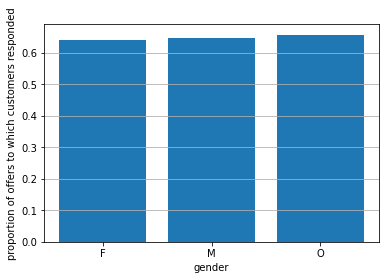

In [256]:
plt.bar(mer.gender, mer.send_offers_success_rate)
plt.grid(axis='y')
plt.ylabel('proportion of offers to which customers responded')
plt.xlabel('gender')

Conclusion:
1) We can see that the differences in response rate are very small for each gender type.  
2) Other gender type was the most responsive to the offers send to them.  
3) Males were more responsive to the offers send to them.  

We can use the above information when we will send offers to various people to predict the chanses that someone will respond to the offer.

Now lets take a look at how different gender types responded to each offer type
    

In [84]:
data_cat5.columns

Index(['person', 'offer_id', 'successful', 'age', 'id_x', 'became_member_on',
       'income', 'age_group_1', 'age_group_2', 'age_group_3', 'age_group_4',
       'income_group_1', 'income_group_2', 'income_group_3', 'income_group_4',
       'gender_group_M', 'gender_group_O', 'time', 'time_group_1',
       'time_group_2', 'time_group_3', 'time_group_4', 'reward', 'channels',
       'difficulty', 'duration', 'id_y', 'gender', 'offer_type_discount',
       'offer_type_informational'],
      dtype='object')

In [88]:
# send_offers_success_rate by gender and offer_type
# create dataframe with sum of all successful offers of each type send to each gender type

# create dataframe with sum of each kind of successful offers send to each gender

df_sex_sum = pd.DataFrame(data_cat5.groupby(['gender', 'offer_type'])['successful'].sum()).reset_index()

# create dataframe with counts of each kind of successful offers send to each gender

df_sex_count = pd.DataFrame(data_cat5.groupby(['gender', 'offer_type'])['successful'].count()).reset_index()

mer = pd.merge(df_sex_sum, df_sex_count, on = ['gender', 'offer_type'])
mer['send_offers_success_rate'] = mer.successful_x/mer.successful_y

In [89]:
mer.sort_values(['gender', 'send_offers_success_rate'])

,gender,offer_type,successful_x,successful_y,send_offers_success_rate
0,F,bogo,3575,7001,0.510641
1,F,discount,3835,5850,0.655556
2,F,informational,3020,3378,0.894020
3,M,bogo,4893,9691,0.504901
4,M,discount,5646,8382,0.673586
5,M,informational,4081,4528,0.901281
6,O,bogo,131,243,0.539095
7,O,discount,152,238,0.638655
8,O,informational,123,136,0.904412


Conclusion: 
   
1) For each offer type other type of gender responded the most to the offers send.   
    Men were less likely to respond to the offer received.  
2) Informational offers had the biggest success rate.  
3) Discount offers were on the second place and bogo on the third place regardless of the gender.   

## Question 2

##  What is the distribution of new customers comming to starbucks?

In [98]:
new_data = pd.DataFrame([])
new_data['year'] = profile.became_member_on.dt.year
new_data['month'] = profile.became_member_on.dt.month
new_data['day'] = profile.became_member_on.dt.day

In [99]:
monthly_counts = new_data.groupby(['year', 'month']).count().reset_index()

In [100]:
# create dummy variables of channel
monthly_counts['year_month'] = monthly_counts['year'].astype(str)+ '-'+ monthly_counts['month'].astype(str)

In [101]:
monthly_counts.sort_values(['year','month'], inplace=True)

In [106]:
[i for i in range(0,monthly_counts.shape[0],4)]

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60]

In [108]:
monthly_counts.year_month[[1,2,3]]

1     2013-8
2     2013-9
3    2013-10
Name: year_month, dtype: object

Text(0.5, 1.0, 'Number of new customers by date')

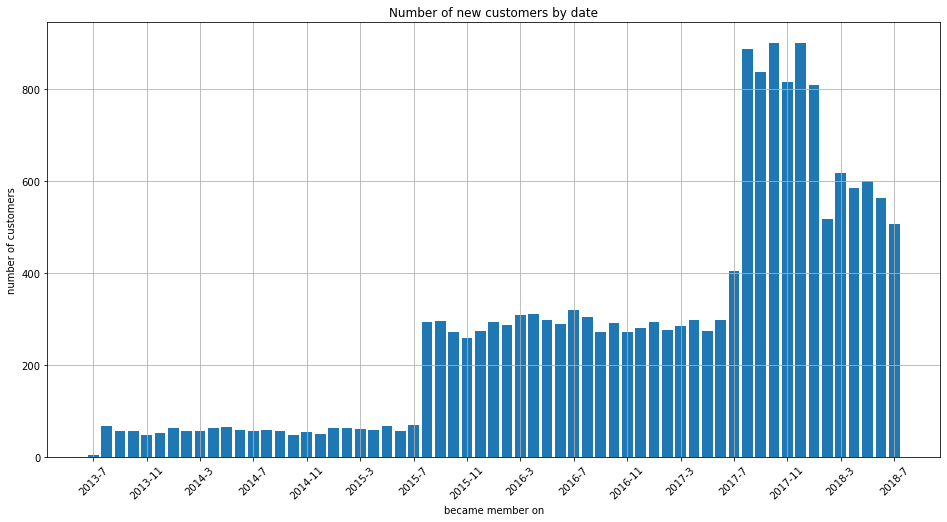

In [111]:
ticks = monthly_counts.year_month[[i for i in range(0,monthly_counts.shape[0],4)]]
plt.figure(figsize=(16,8))
plt.bar(x = monthly_counts.year_month, height = monthly_counts.day)
plt.xticks(ticks=ticks, rotation=45)
plt.grid()
plt.xlabel('became member on')
plt.ylabel('number of customers')
plt.title('Number of new customers by date')

Conclusion:  
In general there is increasing trend of the number of new customers over time. The trend is not smooth it is growing rapidly at some moments what might be a result of campaigns which take place at certain time. However in the recent months there was a drop in the number of new Starbucks members.

## Question 3

## How different age groups responded to the offers send to them?

In [92]:
# age
# categorize 
new_data = categorize(data_cat5, 'age', 4)

# create dataframe with sum of each successful offers send to each age group

df_age_sum = pd.DataFrame(new_data.groupby(['age_categorized'])['successful'].sum()).reset_index()

# create dataframe with count of offers send to each age group
df_age_count = pd.DataFrame(new_data.groupby(['age_categorized'])['successful'].count()).reset_index()

mer = pd.merge(df_age_sum, df_age_count, on = ['age_categorized'])
mer.rename(columns={'successful_x': 'succesful offers', 'successful_y': 'all offers'}, inplace=True)
mer['offer_success_rate'] = mer['succesful offers']/mer['all offers']

In [93]:
mer

,age_categorized,succesful offers,all offers,offer_success_rate
0,0,104,168,0.619048
1,1,2266,3777,0.599947
2,2,2699,3987,0.676950
3,3,2834,4153,0.682398
4,4,19805,27362,0.723814


Conclusion:  
older age groups were more likely to responded to offers send to them 

Let us visualize these numbers

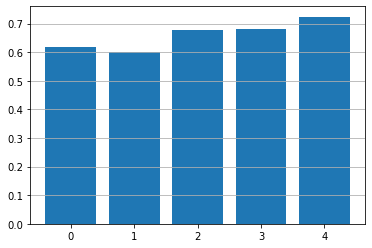

In [95]:

plt.bar(mer.age_categorized, mer.offer_success_rate)
plt.grid(axis='y')

## Question 4

## How different income groups responded to the offers send to them?

In [96]:
# income
# categorize 
new_data = categorize(data_cat5, 'income', 4)

# create dataframe with sum of each successful offers send to each income group
df_age_sum = pd.DataFrame(new_data.groupby(['income_categorized'])['successful'].sum()).reset_index()

# create dataframe with count of each offer send to each income group
df_age_count = pd.DataFrame(new_data.groupby(['income_categorized'])['successful'].count()).reset_index()

mer = pd.merge(df_age_sum, df_age_count, on = ['income_categorized']) 
mer.rename(columns={'successful_x': 'succesful offers', 'successful_y': 'all offers'}, inplace=True)
mer['offer_success_rate'] = mer['succesful offers']/mer['all offers']

In [97]:
mer

,income_categorized,succesful offers,all offers,offer_success_rate
0,0,112,210,0.533333
1,1,2394,4167,0.574514
2,2,2171,3708,0.585491
3,3,2869,4324,0.663506
4,4,20162,27038,0.745691


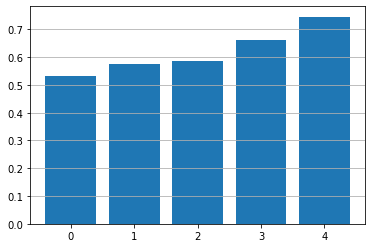

In [98]:
plt.bar(mer.income_categorized, mer.offer_success_rate)
plt.grid(axis='y')

Conclusion:  
The richer is the group the more they responded to the offers 

## Question 5

## How different income and age groups responded to the offers send to them?

In [99]:
# income, age
# categorize 
new_data = categorize(data_cat5, 'age', 4)
new_data = categorize(new_data, 'income', 4)

# create a dataframe with sum of each successful offers send to each age and income group
df_income_sum = pd.DataFrame(new_data.groupby(['age_categorized', 'income_categorized'])['successful'].sum()).reset_index()
df_income_count = pd.DataFrame(new_data.groupby(['age_categorized', 'income_categorized'])['successful'].count()).reset_index()

# create dataframe with count of each offer send to each age and income group
df_income_sum.rename(columns={'age_categorized': 'age_s', 'income_categorized': 'income_s', 'successful': 'sum'}, inplace=True)
df_income_count.rename(columns={'age_categorized': 'age_c', 'income_categorized': 'income_c', 'successful': 'count'}, inplace=True)

df_income_sum.rename(columns={'successful': 'sum'})
con = pd.concat([df_income_sum, df_income_count], axis=1)

con['offer_success_rate'] = con['sum']/con['count']

In [101]:
con[['age_s', 'income_s', 'offer_success_rate']].sort_values(['age_s', 'offer_success_rate'])

,age_s,income_s,offer_success_rate
2,0,2,0.568182
4,0,4,0.574074
3,0,3,0.680000
1,0,1,0.700000
0,0,0,NaN
5,1,0,0.522727
6,1,1,0.550995
7,1,2,0.573107
9,1,4,0.616236
8,1,3,0.668529


Conclusion:  
In general in all age groups when income group was bigger the bigger was offer success rate.  
Thus, rich older peaple were more likeli to respond to offers send to them

## 5) become member on and offer success rate 

In [102]:
# income, age
# categorize 
new_data = categorize(data_cat5, 'time', 4)

# create a dataframe with sum of each successful offers send to each 'time' group
df_income_sum = pd.DataFrame(new_data.groupby(['time_categorized'])['successful'].sum()).reset_index()

# create a dataframe with sum of each successful offers send to each 'time' group
df_income_count = pd.DataFrame(new_data.groupby(['time_categorized'])['successful'].count()).reset_index()

df_income_sum.rename(columns={'successful': 'sum'}, inplace=True)
df_income_count.rename(columns={'successful': 'count'}, inplace=True)

# df_income_sum.rename(columns={'successful': 'sum'})#, axis=columns, inplace=True)
con = pd.concat([df_income_sum, df_income_count], axis=1)

con['offer_success_rate'] = con['sum']/con['count']
con

,time_categorized,sum,time_categorized,count,offer_success_rate
0,0,4,0,4,1.000000
1,1,3201,1,4605,0.695114
2,2,3689,2,4611,0.800043
3,3,3732,3,4627,0.806570
4,4,19100,4,32200,0.593168


Conclusion:  
Here it is difficult to find any correlation between time someone spends with the Starbucks and offer success rate

# Data Modelling

In this part we will train several models which will predict whether an offer send to a given customer will be successful or not.  
Later we will evaluate and visualize models performance and select best classifier. 

In [103]:
data = data_cat5

Select columns which will be used in our model.

In [104]:
cols_to_keep = ['age_group_1', 'age_group_2','age_group_3', 'age_group_4', 
                'income_group_1', 'income_group_2', 'income_group_3', 'income_group_4', 
                'gender_group_M', 'gender_group_O',
                'time_group_1', 'time_group_2', 'time_group_3', 'time_group_4',
                'offer_type_discount', 'offer_type_informational']

In [105]:
X = data[cols_to_keep]
y = data['successful']

Split data in train and test set.

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Instantiate classifiers:

In [110]:
rfc = RandomForestClassifier()
lr = LogisticRegression()
xgbc =  xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False)

### Train classifiers:

Try with default parameters:

In [111]:
rfc.fit(X_train, y_train)
lr.fit(X_train, y_train)
xgbc.fit(X_train, y_train, eval_metric='logloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [113]:
# predict on test data

rfc_y_pred = rfc.predict(X_test)
lr_y_pred = lr.predict(X_test)
xgbc_y_pred = xgbc.predict(X_test)

Check models accuracy:

In [114]:
np.mean(rfc_y_pred == y_test), np.mean(lr_y_pred == y_test), np.mean(xgbc_y_pred == y_test)

(0.7450597176981542, 0.7393412956930873, 0.7475931958016648)

Now let us find best parameters for each model using grid search cross validation technique. We will test only small number of possible parameters because checking bigger grid space is very time consuming.

In [115]:
# find best parameters with the use of cross validation

param_rfc = {'bootstrap': [True,False],
             'ccp_alpha': [0.0, 0.5],
             'max_depth': [None, 3],
             'max_leaf_nodes': [None,3] ,
             'min_samples_split': [2,3],
             'n_estimators': [100,150]}

param_lr = {
             'l1_ratio': [None,0.2,0.5],
             'max_iter': [100,200],
             'penalty': [ 'l2', 'elasticnet', 'none'],
             }

param_xgbc = {
                 'learning_rate': [0.2, 0.5],
                 'max_depth': [None, 3],
                 'n_estimators': [100,150],
                 'num_parallel_tree': [2,5],
             }

cv_rfc = GridSearchCV(rfc, param_rfc)
cv_lr = GridSearchCV(lr, param_lr)
cv_xgbc = GridSearchCV(xgbc, param_xgbc)

cv_rfc.fit(X_train, y_train)
cv_lr.fit(X_train, y_train)
cv_xgbc.fit(X_train, y_train)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on t

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.

[21:35:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:36:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:36:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:37:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:37:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

GridSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=12,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact',
                                     use_label_enc

Asses best parameters of each classifier.

In [116]:
cv_rfc.best_params_

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'max_depth': None,
 'max_leaf_nodes': None,
 'min_samples_split': 2,
 'n_estimators': 100}

In [117]:
cv_lr.best_params_

{'l1_ratio': None, 'max_iter': 100, 'penalty': 'none'}

In [118]:
cv_xgbc.best_params_

{'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 150,
 'num_parallel_tree': 2}

Instatiate and train models with best parameters:

In [119]:
rfc = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, max_depth=None, 
                max_leaf_nodes=None, min_samples_split=2, n_estimators=100)

lr = LogisticRegression(l1_ratio = None, max_iter = 100, penalty = 'none')

xgbc =  xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False,
        learning_rate = 0.5, max_depth = 3, n_estimators = 100, num_parallel_tree = 2)

In [120]:
rfc.fit(X_train, y_train)
lr.fit(X_train, y_train)
xgbc.fit(X_train, y_train)

[21:38:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=2, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Validate models

In [121]:
# get predictions on test set

rfc_probas_pred_test = rfc.predict_proba(X_test)[:,1]
lr_probas_pred_test = lr.predict_proba(X_test)[:,1]
xgbc_probas_pred_test = xgbc.predict_proba(X_test)[:,1]

# get predictions on train set

rfc_probas_pred_train = rfc.predict_proba(X_train)[:,1]
lr_probas_pred_train = lr.predict_proba(X_train)[:,1]
xgbc_probas_pred_train = xgbc.predict_proba(X_train)[:,1]

# assess points to plot precision recall curve for test data 

rfc_prec_test, rfc_rec_test, rfc_thr = precision_recall_curve(y_test, rfc_probas_pred_test)
lr_prec_test, lr_rec_test, lr_thr = precision_recall_curve(y_test, lr_probas_pred_test)
xgbc_prec_test, xgbc_rec_test, xgbc_thr = precision_recall_curve(y_test, xgbc_probas_pred_test)

# assess points to plot precision recall curve for train data 

rfc_prec_train, rfc_rec_train, rfc_thr = precision_recall_curve(y_train, rfc_probas_pred_train)
lr_prec_train, lr_rec_train, lr_thr = precision_recall_curve(y_train, lr_probas_pred_train)
xgbc_prec_train, xgbc_rec_train, xgbc_thr = precision_recall_curve(y_train, xgbc_probas_pred_train)

# assess points to plot ROC curve for test data 

rfc_fpr_test, rfc_tpr_test, rfc_thr = roc_curve(y_test, rfc_probas_pred_test)
lr_fpr_test, lr_tpr_test, lr_thr = roc_curve(y_test, lr_probas_pred_test)
xgbc_fpr_test, xgbc_tpr_test, xgbc_thr = roc_curve(y_test, xgbc_probas_pred_test)

# assess points to plot ROC curve for train data 

rfc_fpr_train, rfc_tpr_train, rfc_thr = roc_curve(y_train, rfc_probas_pred_train)
lr_fpr_train, lr_tpr_train, lr_thr = roc_curve(y_train, lr_probas_pred_train)
xgbc_fpr_train, xgbc_tpr_train, xgbc_thr = roc_curve(y_train, xgbc_probas_pred_train)


Let's visualize models performance plot in order to make comparisson between the models

Text(0, 0.5, 'TPR')

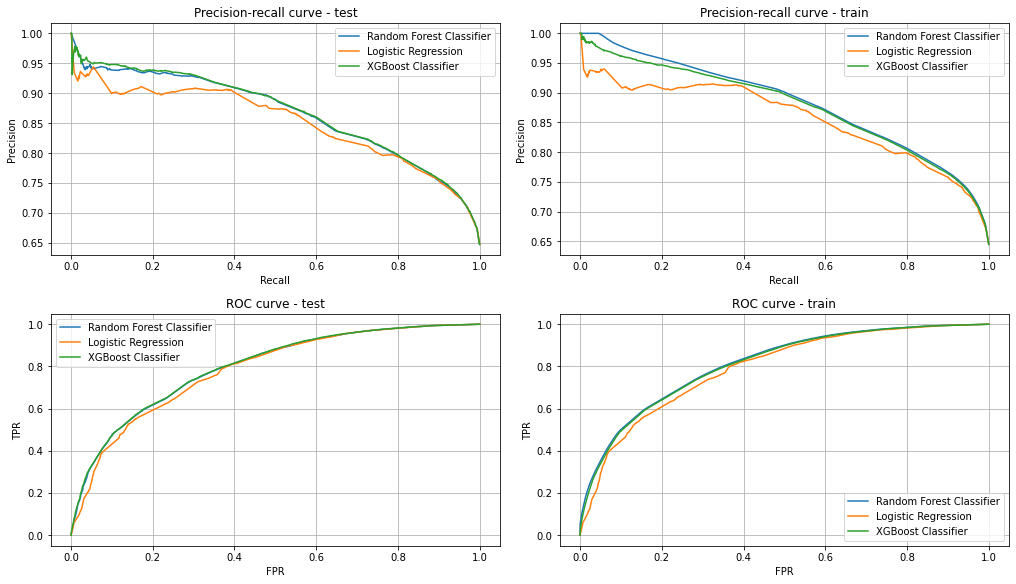

In [123]:

# divide the chart into 4 pieces
fig, ax =plt.subplots(2,2,figsize=(14,8), constrained_layout=True)

# draw each model precision recall curve for test data

ax[0,0].plot(rfc_rec_test, rfc_prec_test, label='Random Forest Classifier')
ax[0,0].plot(lr_rec_test, lr_prec_test, label='Logistic Regression')
ax[0,0].plot(xgbc_rec_test, xgbc_prec_test, label='XGBoost Classifier')
ax[0,0].grid()
ax[0,0].set_title('Precision-recall curve - test')
ax[0,0].set_xlabel('Recall')
ax[0,0].legend()
ax[0,0].set_ylabel('Precision')

# draw each model precision recall curve for train data

ax[0,1].plot(rfc_rec_train, rfc_prec_train, label='Random Forest Classifier')
ax[0,1].plot(lr_rec_train, lr_prec_train, label='Logistic Regression')
ax[0,1].plot(xgbc_rec_train, xgbc_prec_train, label='XGBoost Classifier')
ax[0,1].grid()
ax[0,1].set_title('Precision-recall curve - train')
ax[0,1].set_xlabel('Recall')
ax[0,1].legend()
ax[0,1].set_ylabel('Precision')

# draw each model ROC curve for test data

ax[1,0].plot(rfc_fpr_test, rfc_tpr_test, label='Random Forest Classifier')
ax[1,0].plot(lr_fpr_test, lr_tpr_test, label='Logistic Regression')
ax[1,0].plot(xgbc_fpr_test, xgbc_tpr_test, label='XGBoost Classifier')
ax[1,0].grid()
ax[1,0].set_title('ROC curve - test')
ax[1,0].set_xlabel('FPR')
ax[1,0].legend()
ax[1,0].set_ylabel('TPR')

# draw each model ROC curve for train data

ax[1,1].plot(rfc_fpr_train, rfc_tpr_train, label='Random Forest Classifier')
ax[1,1].plot(lr_fpr_train, lr_tpr_train, label='Logistic Regression')
ax[1,1].plot(xgbc_fpr_train, xgbc_tpr_train, label='XGBoost Classifier')
ax[1,1].grid()
ax[1,1].set_title('ROC curve - train')
ax[1,1].set_xlabel('FPR')
ax[1,1].legend()
ax[1,1].set_ylabel('TPR')

Conclusion:  
From the above plots it is difficult to judge which model performs best
because almost all the curves are overlapping.  
The only thing which can be concluded from the plots above is that logistic regression is performing worse than the rest of the models on train as well as test dataset.
    

### Table with roc_auc, prauc, accuracy and f1-score

In [131]:
# create a dictionary with classifier name and classifier

clfs = {'Logistic Regression': lr, 'XGBoost': xgbc, 'Random Forest Classifier': rfc}

In the cell below we will create a dataframe which will contain evaluation metrics for each classifier for train and test data:

In [132]:
classifier = []
PRAUC_train = []
PRAUC_test = []
AUC_test = []
AUC_train = []
accuracy_train = []
accuracy_test = []
F1_score_test = []
F1_score_train = []

# for each classifier
for clf_name, clf in clfs.items():
    print(clf_name)
    classifier.append(clf_name)
    
#   asses probabilities predictions and class predictions for test set and get values for precision recall curve 
    probas_pred = clf.predict_proba(X_test)[:,1]
    y_pred = clf.predict(X_test)
    prec, rec, _ = precision_recall_curve(y_test, probas_pred)
    
#   compute area under precision recall curev - PRAUC
    PRAUC_test.append(auc(rec, prec))

#   compute area under ROC cure - AUC
    AUC_test.append(roc_auc_score(y_test, probas_pred))
    
#   compute accuracy score
    accuracy_test.append(accuracy_score(y_test, y_pred))
    
#   compute F1 score
    F1_score_test.append(f1_score(y_test, y_pred))
    
    
#   asses probabilities predictions and class for train set and get values for precision recall curve 
    probas_pred = clf.predict_proba(X_train)[:,1]
    y_pred = clf.predict(X_train)
    prec, rec, _ = precision_recall_curve(y_train, probas_pred)
    
#   compute area under precision recall curev - PRAUC
    PRAUC_train.append(auc(rec, prec))

#   compute area under ROC cure - AUC
    AUC_train.append(roc_auc_score(y_train, probas_pred))

#   compute accuracy score
    accuracy_train.append(accuracy_score(y_train, y_pred))

#   compute F1 score
    F1_score_train.append(f1_score(y_train, y_pred))
    

# create a dataframe with computed values
df = pd.DataFrame({
    'classifier': classifier, 
    'PRAUC_train': PRAUC_train, 'AUC_train': AUC_train, 'accuracy_train': accuracy_train, 'F1_score_train': F1_score_train,
    'PRAUC_test': PRAUC_train, 'AUC_test': AUC_test, 'accuracy_test': accuracy_test, 'F1_score_test': F1_score_test})


Logistic Regression
XGBoost
Random Forest Classifier


In [133]:
df

,classifier,PRAUC_train,AUC_train,accuracy_train,F1_score_train,PRAUC_test,AUC_test,accuracy_test,F1_score_test
0,Logistic Regression,0.856508,0.792511,0.743516,0.810264,0.856508,0.783690,0.739341,0.807361
1,XGBoost,0.876407,0.809132,0.756236,0.826345,0.876407,0.797682,0.748172,0.820809
2,Random Forest Classifier,0.882446,0.813496,0.758563,0.828045,0.882446,0.795991,0.746001,0.819524


Conclusion:  
From the above table we can conclude that:  
- Random Forest Classifier and XGBoost models performed the best.  
- Random Forest Classifier has the best performance on the train set.  
- However XGBoost model has the best performance in terms AUC on test set. 
  On all other metrics Random Forest Classifier is performing the best
  
In our problem statement we want to choose the model which best predicts whether a certain offer will be successful
or not so that we should choose the model with the best accuracy score on test set which as Random Forest Classifier model

In [137]:
!python -V

Python 3.7.6
